In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.preprocessing import LabelEncoder,label_binarize,StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2,SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import gc
import re
import string
from nltk.stem import PorterStemmer
warnings.filterwarnings("ignore")



In [23]:
def load_and_sample_data(sample_size=20000):
    splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
    dfs = {}
    for split, file in splits.items():
        df = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + file)
        print(f"Original {split} dataset size: {len(df)}")
        if len(df) > sample_size:
            df = df.sample(n=sample_size, random_state=42)
            print(f"Sampled {split} to {len(df)} rows for faster training")
        dfs[split] = df
    return dfs['train'], dfs['validation'], dfs['test']


In [24]:
train_df, val_df, test_df = load_and_sample_data()

Original train dataset size: 31232
Sampled train to 20000 rows for faster training
Original validation dataset size: 5205
Original test dataset size: 5206


In [25]:
def text_preprocessing(text):
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Handle contractions better
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'m", " am", text)
    
    # Remove URLs, HTML tags, and email addresses
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Handle repeated characters (e.g., "sooo good" -> "so good")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Remove numbers but keep emoticons
    text = re.sub(r'\d+', '', text)
    
    # # Keep some punctuation that might be important for sentiment
    text = re.sub(r'[^\w\s!?]', ' ', text)
    return text



In [26]:
from collections import Counter

ps = PorterStemmer()

import nltk
nltk.download("stopwords", download_dir="D:/7th SEMESTER/Machine Learning/modelnew/nltk_data")
with open('nltk_data/corpora/stopwords/english', 'r') as file:
    stopwords = set(file.read().splitlines())




[nltk_data] Downloading package stopwords to D:/7th SEMESTER/Machine
[nltk_data]     Learning/modelnew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def plot_roc_curves(y_true, y_pred_proba, classes, model_name):
    """Plot ROC curves for multiclass classification"""
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()



In [28]:
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [ ]:
def plot_learning_curves(model, X, y, model_name, cv=5):
    """Plot learning curves for a given model"""
    # Define training set sizes
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=train_sizes,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        random_state=42
    )
    
    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot training scores
    plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', 
             label='Training Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    
    # Plot validation scores
    plt.plot(train_sizes_abs, val_mean, 'o-', color='red', 
             label='Validation Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='red')
    
    # Customize the plot
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('F1 Score (Weighted)', fontsize=12)
    plt.title(f'Learning Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add performance indicators
    final_train_score = train_mean[-1]
    final_val_score = val_mean[-1]
    gap = final_train_score - final_val_score
    
    
    # Color-code the gap interpretation
    if gap > 0.5:
        gap_color = 'red'
        gap_text = 'High Overfitting'
    elif gap > 0.1:
        gap_color = 'orange'
        gap_text = 'Moderate Overfitting'
    else:
        gap_color = 'green'
        gap_text = 'Good Generalization'
    
    plt.text(0.98, 0.02, f'Status: {gap_text}', transform=plt.gca().transAxes, 
             fontsize=11, ha='right', va='bottom',
             bbox=dict(boxstyle='round', facecolor=gap_color, alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    return train_sizes_abs, train_mean, val_mean

In [40]:
def plot_all_learning_curves(results, X, y, cv=5):
    """Plot learning curves for all trained models"""
    print("\n" + "="*60)
    print("GENERATING LEARNING CURVES FOR ALL MODELS")
    print("="*60)
    
    learning_data = {}
    
    for model_name, result in results.items():
        print(f"\nGenerating learning curve for {model_name}...")
        model = result['model']
        
        try:
            train_sizes, train_scores, val_scores = plot_learning_curves(
                model, X, y, model_name, cv
            )
            learning_data[model_name] = {
                'train_sizes': train_sizes,
                'train_scores': train_scores,
                'val_scores': val_scores
            }
        except Exception as e:
            print(f"Error generating learning curve for {model_name}: {str(e)}")
    
    return learning_data
    

In [41]:
x_train = train_df["text"]
y_train = train_df["sentiment"]
x_val = val_df["text"]
y_val = val_df["sentiment"]
x_test = test_df["text"]
y_test = test_df["sentiment"]

print(f"Training set: {x_train.shape}, Test set: {x_test.shape}, Validation set: {x_val.shape}")



Training set: (20000,), Test set: (5206,), Validation set: (5205,)


In [42]:
def create_vectorizer():
    return TfidfVectorizer(
        max_features=8000,        # Increased features
        min_df=10,                  # Reduced min_df for more features
        max_df=0.7,               # Slightly increased max_df
        stop_words='english',
        ngram_range=(1, 2),        # Include trigrams
        sublinear_tf=True,         # Apply sublinear tf scaling
        norm='l2',
        use_idf=True,
        smooth_idf=True,
        lowercase=True,
        token_pattern=r'[a-zA-Z]{3,}',
        binary=False,              
        strip_accents='unicode'
    )

tfidf_vec = create_vectorizer()




In [43]:
def detailed_scores(y_true, y_pred, dataset_name="Dataset"):
    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f'\n{dataset_name} Scores:')
    print(f'  Accuracy: {acc:.4f}')
    print(f'  Weighted F1: {f1_weighted:.4f}')
    print(f'  Macro F1: {f1_macro:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    
    return acc, f1_weighted, f1_macro



In [51]:
def create_feature_pipeline():
    return Pipeline([
        ('feature_selection', SelectPercentile(chi2, percentile=80)),  # Keep top 80% of features
        ('svd', TruncatedSVD(n_components=2000, random_state=42)),     # Dimensionality reduction
        ('scaler', StandardScaler())                                   # Standardize features
    ])



In [52]:
def get_model_probabilities(model, X, label_encoder):
    
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X)
    elif hasattr(model, 'decision_function'):
        decision_scores = model.decision_function(X)
        
        
        if decision_scores.ndim == 1:
            probabilities = np.column_stack([1 - decision_scores, decision_scores])
        else:
            exp_scores = np.exp(decision_scores - np.max(decision_scores, axis=1, keepdims=True))
            probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    else:
        # Fallback: use predict and create dummy probabilities
        predictions = model.predict(X)
        n_classes = len(label_encoder.classes_)
        probabilities = np.zeros((len(predictions), n_classes))
        for i, pred in enumerate(predictions):
            probabilities[i, pred] = 1.0
    
    return probabilities

In [53]:
def train_multiple_models(x_train, x_val, x_test, y_train, y_val, y_test):

    print("Applying text preprocessing...")
    x_train_processed = [text_preprocessing(text) for text in x_train]
    x_val_processed = [text_preprocessing(text) for text in x_val]
    x_test_processed = [text_preprocessing(text) for text in x_test]

    # Vectorize processed text
    tfidf_vec = create_vectorizer()
    x_train_vectorized = tfidf_vec.fit_transform(x_train_processed)
    x_val_vectorized = tfidf_vec.transform(x_val_processed)
    x_test_vectorized = tfidf_vec.transform(x_test_processed)

    # Initialize and fit LabelEncoder
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    print("Applying feature selection...")
    feature_pipeline = create_feature_pipeline()
    x_train_processed_features = feature_pipeline.fit_transform(x_train_vectorized, y_train_encoded)
    x_val_processed_features = feature_pipeline.transform(x_val_vectorized)
    x_test_processed_features = feature_pipeline.transform(x_test_vectorized)

    # validation
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    models = {
        'Regularized Logistic Regression': {
            'model': LogisticRegression(
                random_state=42, 
                max_iter=1000,
                class_weight='balanced',
                fit_intercept=True,
                multi_class='multinomial'
            ),
            'params': {
                'C': [0.0001, 0.001, 0.01],  # Stronger regularization
                'penalty': ['l2'],   # Try both L1 and L2
            }
        },
        'Regularized Linear SVM': {
            'model': LinearSVC(
                random_state=42, 
                max_iter=2000,
                class_weight='balanced',
                dual=False,
            ),
            'params': {
                'C': [0.0001, 0.001, 0.01],  # Stronger regularization
                'penalty': ['l2'],
                'loss': ['hinge', 'squared_hinge']
            }
        },
        'Regularized Random Forest': {
            'model': RandomForestClassifier(
                random_state=42, 
                class_weight='balanced',
                n_jobs=-1,
                bootstrap=True,
                oob_score=True,    
            ),
            'params': {
                'n_estimators': [100],
                'max_depth': [5],      # Reduced depth
                'min_samples_split': [50], # Increased
                'min_samples_leaf': [25],  # Increased
                'max_features': ['sqrt', 'log2'],  # More restrictive
                'max_samples': [0.6],
                'min_impurity_decrease': [0.001]      # Bootstrap sampling ratio
            }
        }
    }
    
    results = {}
    classes = label_encoder.classes_
    
    for name, config in models.items():
        print(f"\n{'='*60}")
        print(f"Training {name}...")

        gc.collect()
        
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=cv_strategy,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1,
            return_train_score=True
        )
        
        # Fit the model
        grid_search.fit(x_train_processed_features, y_train_encoded)
        
        # Get best model
        best_model = grid_search.best_estimator_
        
        # Make predictions
        y_train_pred = best_model.predict(x_train_processed_features)
        y_val_pred = best_model.predict(x_val_processed_features)
        y_test_pred = best_model.predict(x_test_processed_features)
        
        y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        
        # Calculate scores
        train_acc, train_f1_w, train_f1_m = detailed_scores(y_train, y_train_pred_decoded, "Training")
        test_acc, test_f1_w, test_f1_m = detailed_scores(y_test, y_test_pred_decoded, "Test")
        
        
        overfitting_score = train_acc - test_acc
        print(f"\nOverfitting Score (Train - Test): {overfitting_score:.4f}")
        if overfitting_score > 0.05:
            print(" WARNING: Model shows signs of overfitting!")
       
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_f1_weighted': train_f1_w,
            'test_f1_weighted': test_f1_w,
            'overfitting_score': overfitting_score,
            'y_test_pred': y_test_pred_decoded
        }
        
        print(f"\nBest Parameters: {grid_search.best_params_}")
        print(f"Cross-validation Score: {grid_search.best_score_:.4f}")
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_test_pred_decoded, classes, name)
        
        # Get probability predictions for ROC curves
        try:
            print("Generating ROC curves...")
            y_test_proba = get_model_probabilities(best_model, x_test_processed_features, label_encoder)
            plot_roc_curves(y_test_encoded, y_test_proba, np.arange(len(classes)), name)
        except Exception as e:
            print(f"Could not generate ROC curves for {name}: {str(e)}")
    
    return results, label_encoder, tfidf_vec, feature_pipeline


Applying text preprocessing...
Applying feature selection...

Training Regularized Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Training Scores:
  Accuracy: 0.7320
  Weighted F1: 0.7324
  Macro F1: 0.7335
  Precision: 0.7329
  Recall: 0.7320

Test Scores:
  Accuracy: 0.6418
  Weighted F1: 0.6423
  Macro F1: 0.6435
  Precision: 0.6432
  Recall: 0.6418

Overfitting Score (Train - Test): 0.0902

Best Parameters: {'C': 0.0001, 'penalty': 'l2'}
Cross-validation Score: 0.6432


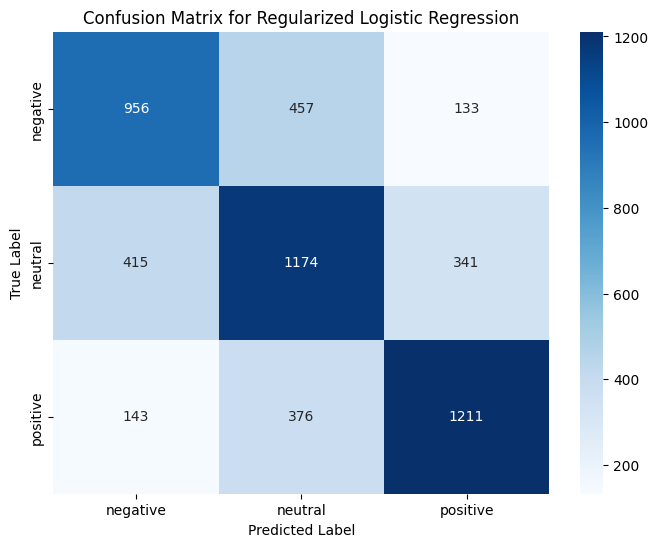

Generating ROC curves...


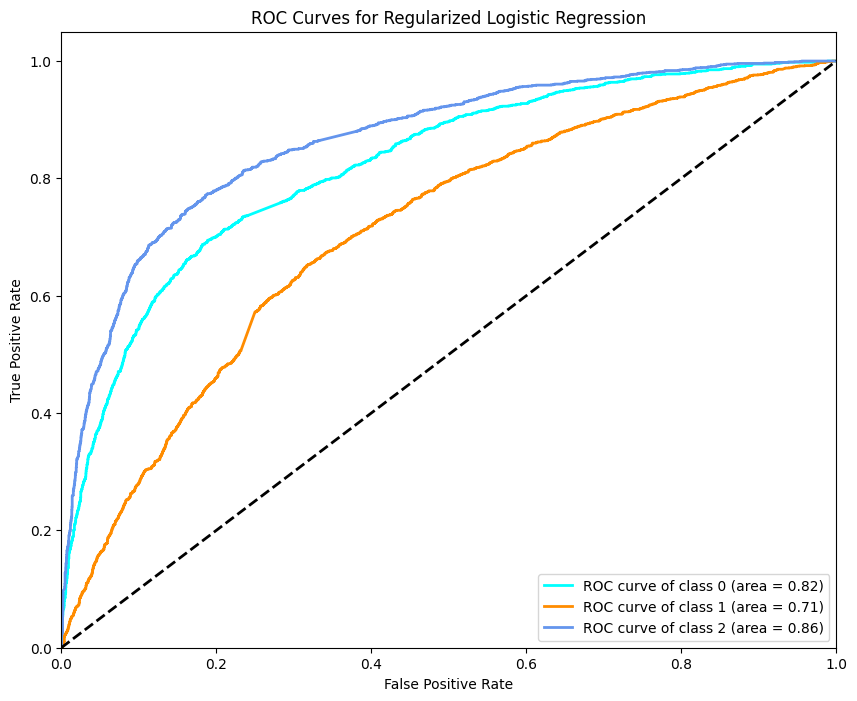


Training Regularized Linear SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Training Scores:
  Accuracy: 0.7347
  Weighted F1: 0.7350
  Macro F1: 0.7359
  Precision: 0.7355
  Recall: 0.7347

Test Scores:
  Accuracy: 0.6437
  Weighted F1: 0.6442
  Macro F1: 0.6452
  Precision: 0.6454
  Recall: 0.6437

Overfitting Score (Train - Test): 0.0910

Best Parameters: {'C': 0.0001, 'loss': 'squared_hinge', 'penalty': 'l2'}
Cross-validation Score: 0.6448


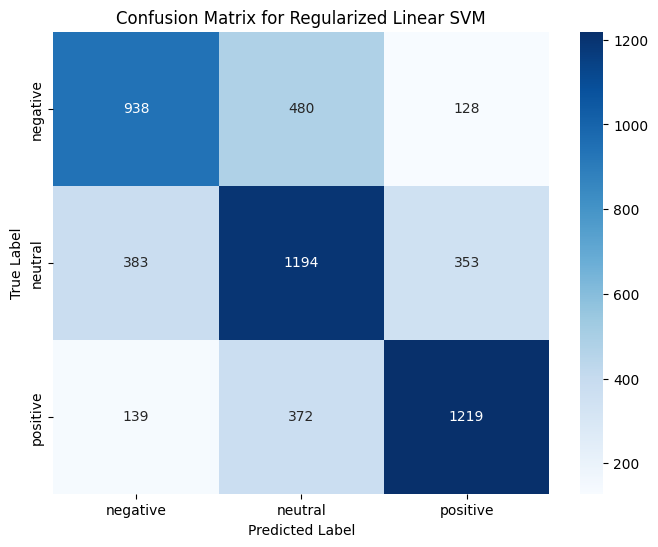

Generating ROC curves...


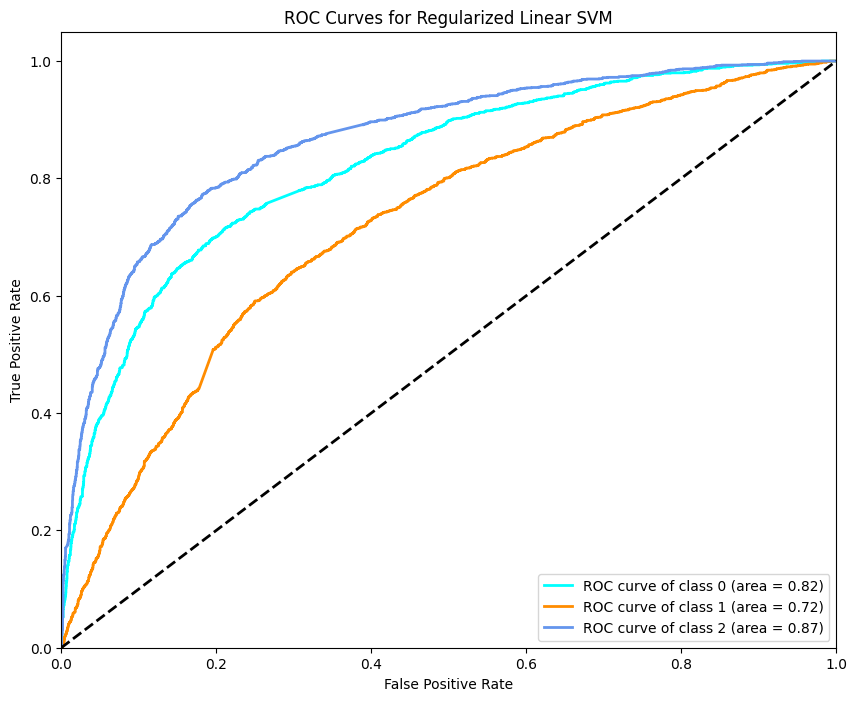


Training Regularized Random Forest...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Training Scores:
  Accuracy: 0.5801
  Weighted F1: 0.5749
  Macro F1: 0.5782
  Precision: 0.5821
  Recall: 0.5801

Test Scores:
  Accuracy: 0.5505
  Weighted F1: 0.5461
  Macro F1: 0.5486
  Precision: 0.5515
  Recall: 0.5505

Overfitting Score (Train - Test): 0.0296

Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'max_samples': 0.6, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 25, 'min_samples_split': 50, 'n_estimators': 100}
Cross-validation Score: 0.5502


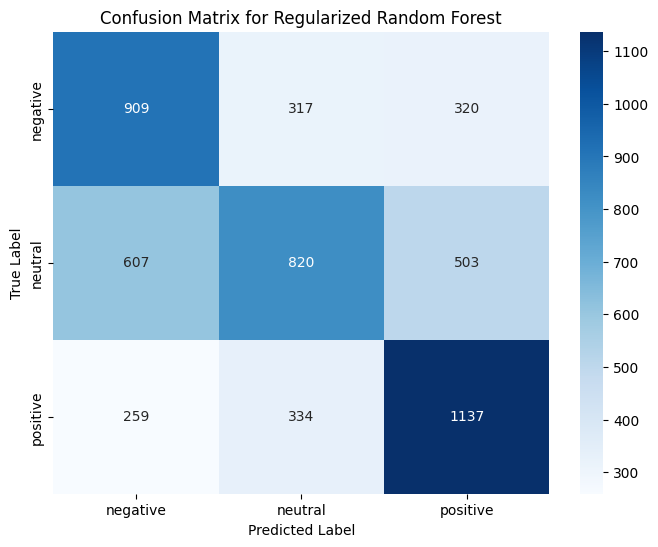

Generating ROC curves...


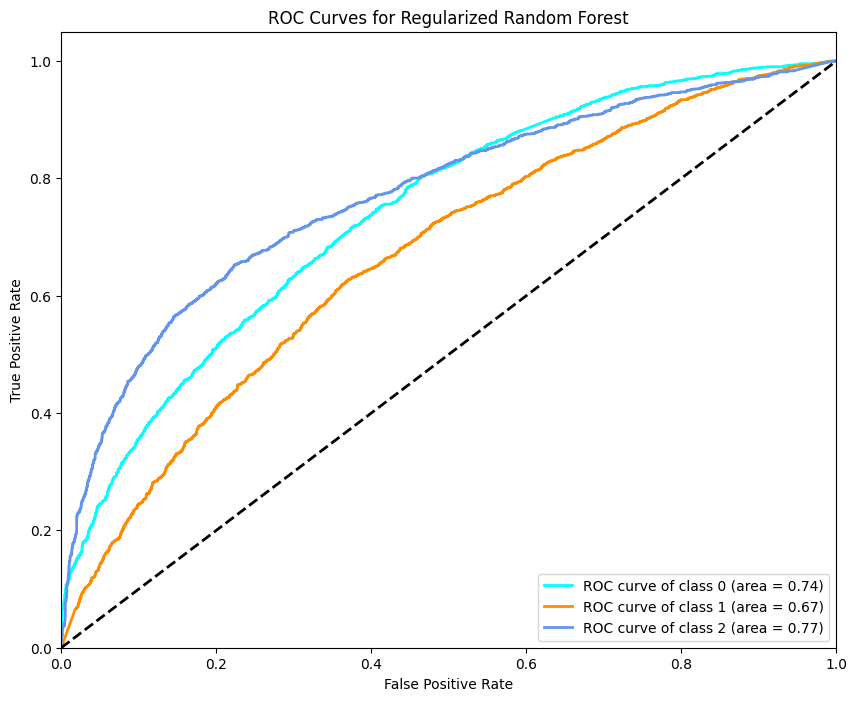

In [54]:
results, label_encoder, tfidf_vec, feature_pipeline_fitted = train_multiple_models(
        x_train, x_val, x_test, y_train, y_val, y_test
    )





Preparing data for learning curves...

GENERATING LEARNING CURVES FOR ALL MODELS

Generating learning curve for Regularized Logistic Regression...


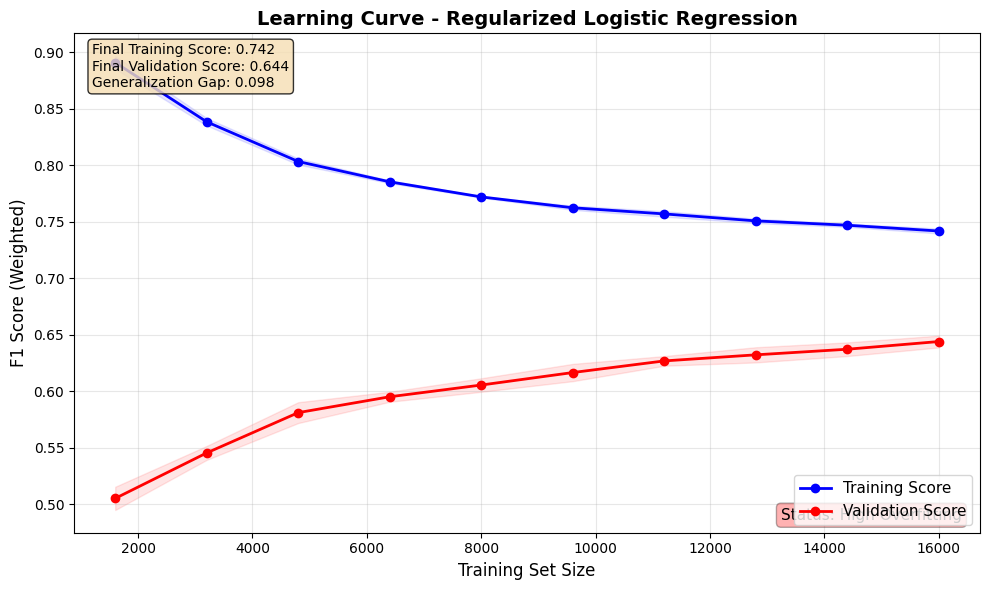


Generating learning curve for Regularized Linear SVM...


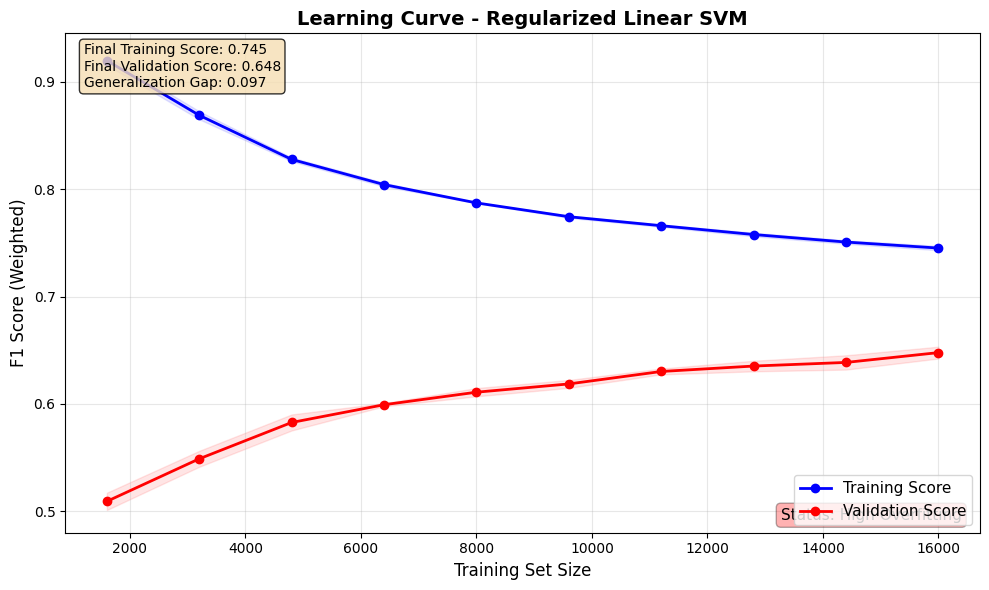


Generating learning curve for Regularized Random Forest...


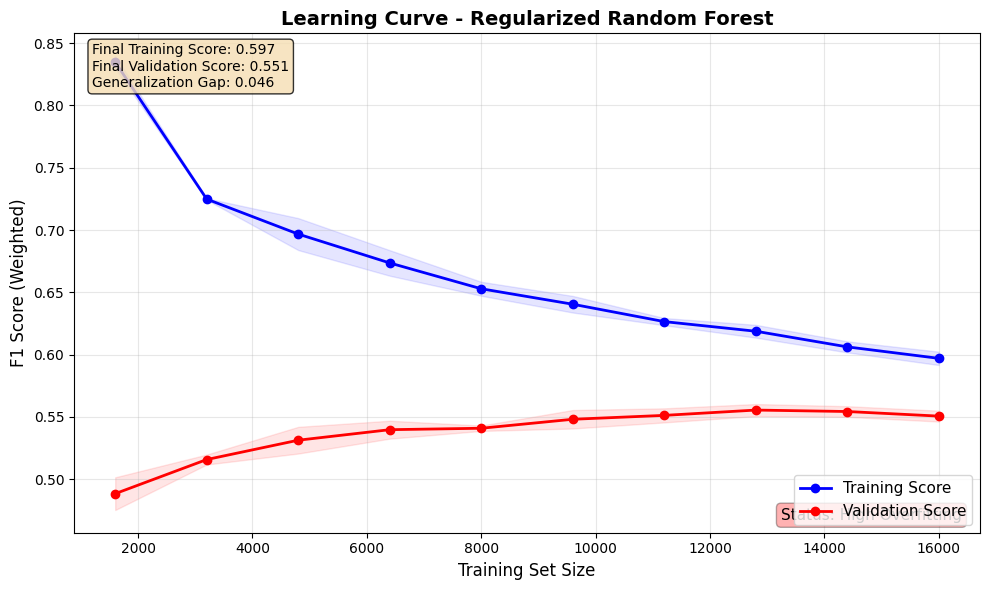

In [55]:
print("Preparing data for learning curves...")
x_train_processed = [text_preprocessing(text) for text in x_train]
x_train_vectorized = tfidf_vec.transform(x_train_processed)
y_train_encoded = label_encoder.transform(y_train)
x_train_processed_features = feature_pipeline_fitted.transform(x_train_vectorized)

learning_data = plot_all_learning_curves(results, x_train_processed_features, y_train_encoded, cv=5)

In [63]:
print(results)

{'logistic_regression': {'model': LogisticRegression()}}


In [70]:
def predict_sentiment(text, vectorizer, model, label_encoder):
    processed_text = text_preprocessing(text)
    vectorized_text = vectorizer.transform([processed_text])
    processed_features = create_feature_pipeline.transform(vectorized_text)
    prediction_encoded = model.predict(processed_features)[0]  
    prediction_decoded = label_encoder.inverse_transform([prediction_encoded])[0]  
    return prediction_decoded